In [1]:
import numpy as np
import torch
from torchvision.models import resnet50
from torch import nn
from torch.utils.data import DataLoader

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from scipy.spatial.distance import cdist
import numpy as np

# Example vectors (rows in a matrix)
vectors = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Compute pairwise Euclidean distances
distances = cdist(vectors, vectors, "euclidean")

print(distances)

[[ 0.          5.19615242 10.39230485]
 [ 5.19615242  0.          5.19615242]
 [10.39230485  5.19615242  0.        ]]


In [3]:
# test_dataset = torch.load("data/test_dataset.pt")
test_pairs = np.load("test_data.npy")
test_labels = np.load("test_labels.npy")

from openset_ds import OpenSet

open_dataset = OpenSet(test_pairs, test_labels)

In [4]:
import os
from torchvision import models

baseline = resnet50(pretrained=True)

baseline.fc = nn.Linear(2048, 910)

if os.path.exists(f"models/BASELINE_89.pt"):
    baseline.load_state_dict(torch.load(f"models/BASELINE_89.pt"))
# if os.path.exists(f"models/resnet50_17epoch_32.pt"):
#     baseline.load_state_dict(torch.load(f"models/resnet50_17epoch_32.pt"))
baseline.fc = torch.nn.Identity()

# baseline = models.squeezenet1_1(pretrained=True)


# bs = 128

# baseline.classifier = torch.nn.Identity()
# # if os.path.exists(f"models/squeezenet_{bs}.pt"):
# #     triplet.load_state_dict(torch.load(f"models/squeezenet_{bs}.pt"))
# if os.path.exists(f"models/sqnet_baseline.pt"):
#     baseline.load_state_dict(torch.load(f"models/sqnet_baseline.pt"))

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from torchvision import models

triplet = models.squeezenet1_1(pretrained=True)


bs = 128

# if os.path.exists(f"models/squeezenet_{bs}.pt"):
#     triplet.load_state_dict(torch.load(f"models/squeezenet_{bs}.pt"))
n_classes = 910
triplet.classifier[1] = torch.nn.Conv2d(512, n_classes, kernel_size=(1, 1))
if os.path.exists(f"models/baseline_sqnet.pt"):
    triplet.load_state_dict(torch.load(f"models/baseline_sqnet.pt"))

triplet.classifier = torch.nn.Identity()
# triplet.classifier = torch.nn.Identity()
# if os.path.exists(f"models/.pt"):
#     triplet.load_state_dict(torch.load(f"models/sqnet.pt"))

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
print(triplet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [7]:
def get_accuracy(embeddings, targets):
    embeddings = np.array(embeddings)
    targets = np.array(targets)

    # Get cosine similarity for all embeddings
    similarity_matrix = cosine_similarity(embeddings)

    # Fill diagonal with inf
    np.fill_diagonal(similarity_matrix, -np.inf)

    # Find the index of max sim for each embedding
    most_similar_indices = np.argmax(similarity_matrix, axis=1)

    # Extract the labels of the most similar items
    predicted_labels = [targets[i] for i in most_similar_indices]
    n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)

    accuracy = 100 * (n_correct / len(embeddings))

    return accuracy, predicted_labels

In [42]:
def get_embeddings(model, dataloader, device):
    embeddings = []
    targets = []

    with torch.no_grad():
        for inputs, labels in dataloader:

            data = inputs.to(device)
            label = labels.to(device)
            batch_emb, batch_lab = [], []

            emb = model(data)

            batch_emb.extend(emb.cpu())
            batch_lab.extend(label.cpu().tolist())

            embeddings.extend(batch_emb)
            targets.extend(batch_lab)

    return embeddings, targets

In [9]:
true_pairs, fake_pairs = [], []

In [48]:
import random


def get_embeddings_accuracy(model, dataloader, device, baseline=False, _random=False):
    global true_pairs, fake_pairs
    true_pairs, fake_pairs = [], []
    n_correct = 0

    tp, fp, tn, fn = 0, 0, 0, 0

    thresh = 0.48  # 0.8221790790557861     # Calculated from train data (validation)
    if baseline:
        thresh = 0.5623701810836792

    with torch.no_grad():
        for inputs, labels in dataloader:
            img1, img2 = inputs[:, 0], inputs[:, 1]
            img1, img2 = img1.to(device), img2.to(device)

            lab1, lab2 = labels[:, 0], labels[:, 1]

            emb1 = model(img1).cpu()
            emb2 = model(img2).cpu()

            sim = cosine_similarity(emb1, emb2)

            for i in range(len(sim)):

                if _random:
                    sim[i][i] = random.random()

                if lab1[i] == lab2[i]:
                    true_pairs.append(sim[i][i])
                else:
                    fake_pairs.append(sim[i][i])
                res = sim[i][i]

                if res > thresh and lab1[i] == lab2[i]:
                    n_correct += 1
                    tp += 1
                if res < thresh and lab1[i] != lab2[i]:
                    n_correct += 1
                    tn += 1
                if res < thresh and lab1[i] == lab2[i]:
                    fn += 1
                if res > thresh and lab1[i] != lab2[i]:
                    fp += 1

    return n_correct, (tp, tn, fp, fn)

In [11]:
test_dataloader = DataLoader(open_dataset, 128, True)

In [12]:
device = "cuda"

In [40]:
baseline = baseline.to(device)

# baseline_emb, baseline_targ = get_embeddings(baseline, test_dataloader, "cuda")
# acc, _ = get_accuracy(baseline_emb, baseline_targ)
n_correct, (tp, tn, fp, fn) = get_embeddings_accuracy(
    baseline, test_dataloader, "cuda", baseline=True
)
print(n_correct)

KeyboardInterrupt: 

In [14]:
baseline_scores = (tp, tn, fp, fn)

In [15]:
n_correct / (len(test_dataloader) * bs)

0.787793464467005

In [16]:
acc = (tp + tn) / (tp + tn + fp + fn)
recall = (tp) / (tp + fn)
precision = (tp) / (tp + fp)
f1 = (tp) / (tp + (fp + fn) / 2)

In [17]:
print(acc, recall, precision, f1)

0.7885439822165767 0.6642120765832106 0.887140398328006 0.7596589114643647


In [18]:
n_correct / len(open_dataset)

0.7885439822165767

In [19]:
# for i in range(len(baseline_emb)):
#     baseline_emb[i] = baseline_emb[i].detach().numpy()

In [20]:
# type(baseline_emb[0])

In [21]:
# baseline_accuracy, baseline_preds = get_accuracy(baseline_emb, baseline_targ)

In [22]:
# baseline_accuracy

In [23]:
len(true_pairs), len(fake_pairs)

(38024, 37552)

In [24]:
np.mean(true_pairs), np.mean(fake_pairs)

(0.60611814, 0.47304258)

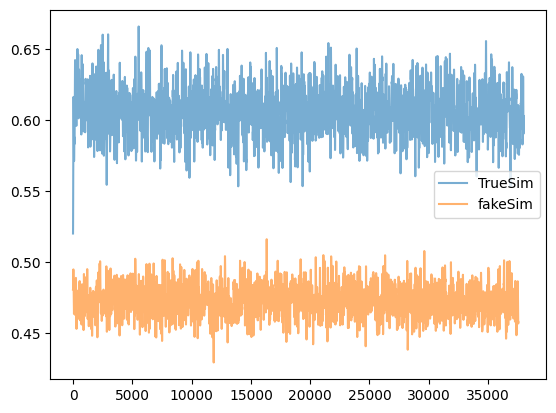

In [25]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(true_pairs, sigma=10), label="TrueSim", alpha=0.6)
plt.plot(gaussian_filter(fake_pairs, sigma=10), label="fakeSim", alpha=0.6)
plt.legend()

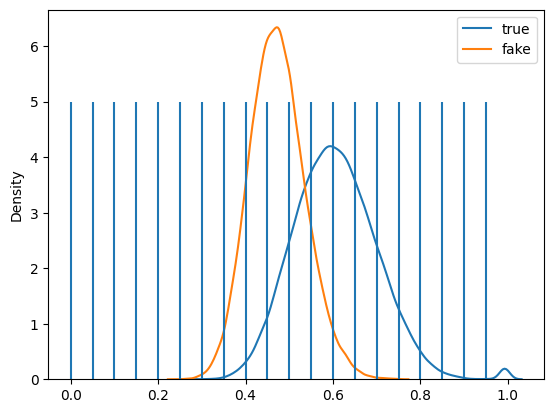

In [26]:
import cv2
import seaborn as sns

sns.kdeplot(true_pairs, label="true")
sns.kdeplot(fake_pairs, label="fake")
plt.legend()
plt.vlines([0.05 * i for i in range(20)], ymin=0, ymax=5)
# plt.plot(true_pairs)
# plt.plot(fake_pairs)

In [44]:
triplet = triplet.to(device)
# triplet_emb, triplet_targ = get_embeddings(triplet, test_dataloader, "cuda")
n_correct, (tp, tn, fp, fn) = get_embeddings_accuracy(triplet, test_dataloader, "cuda")
print(n_correct / len(open_dataset))
# for i in range(len(triplet_emb)):
#     triplet_emb[i] = triplet_emb[i].detach().numpy()

# triplet_accuracy, triplet_preds = get_accuracy(triplet_emb, triplet_targ)
# triplet_accuracy

0.754194453265587


NameError: name 'triplet_emb' is not defined

In [28]:
def get_scores(tp, tn, fp, fn):
    acc = (tp + tn) / (tp + tn + fp + fn)
    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    f1 = (tp) / (tp + (fp + fn) / 2)
    return acc, recall, precision, f1

In [50]:
_, random_scores = get_embeddings_accuracy(
    triplet, test_dataloader, "cuda", _random=True
)

In [51]:
get_scores(*random_scores)

(0.5031359161638616,
 0.5263254786450663,
 0.5059793188885798,
 0.5159518929579644)

In [29]:
acc = (tp + tn) / (tp + tn + fp + fn)
recall = (tp) / (tp + fn)
precision = (tp) / (tp + fp)
f1 = (tp) / (tp + (fp + fn) / 2)
_f1 = 2 * precision * recall / (precision + recall)

In [30]:
print(acc, recall, precision, f1, _f1)
print(get_scores(*baseline_scores))

0.754194453265587 0.7636229749631811 0.7517411003236246 0.7576354551266161 0.7576354551266161
(0.7885439822165767, 0.6642120765832106, 0.887140398328006, 0.7596589114643647)


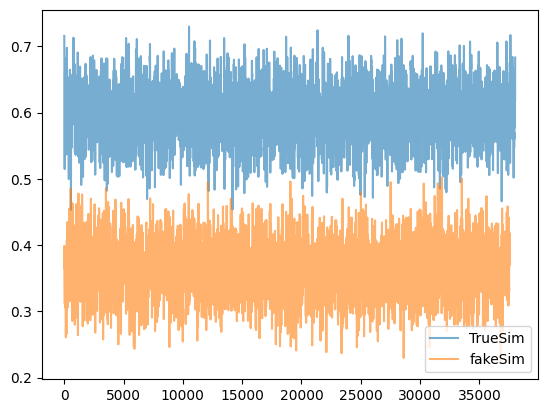

In [31]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(true_pairs, sigma=5), label="TrueSim", alpha=0.6)
plt.plot(gaussian_filter(fake_pairs, sigma=5), label="fakeSim", alpha=0.6)
plt.legend()

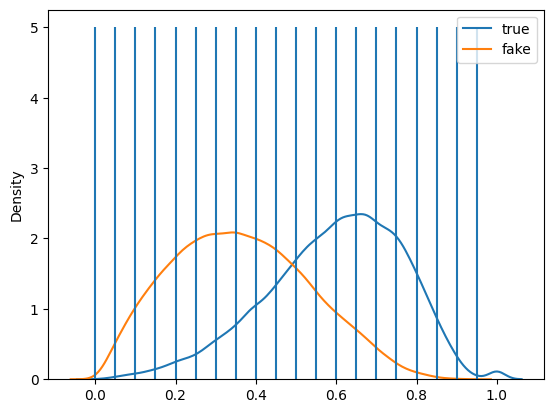

In [32]:
sns.kdeplot(true_pairs, label="true")
sns.kdeplot(fake_pairs, label="fake")
plt.legend()
plt.vlines([0.05 * i for i in range(20)], ymin=0, ymax=5)

In [33]:
print(n_correct / len(open_dataset))

0.754194453265587


In [34]:
print(
    f"Test set with {len(open_dataset)} samples of {len(set(open_dataset.labels))} classes."
)
# print(f"Baseline model openset performance: {baseline_accuracy}")
print(f"Triplet model openset performance: {acc}")

TypeError: unhashable type: 'numpy.ndarray'

TODO: Compare best model performances to majority classifier and specify that the bad model still has some knowledge. Also use random classifier